# In this Jupyter notebook we demonstrate how to build a python Predictive Model with Scikit-learn.

The Dataset for personal loan classification is taken from: https://www.kaggle.com/itsmesunil/bank-loan-modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import seaborn as sns
%matplotlib inline
sns.set(style="ticks")

from scipy.stats import zscore
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection

In [2]:
# Insert Cloud Object Storage Credentials and Load Dataset here.


,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [3]:
# Replace the credentials that you got from Watson Machine Learning service

wml_credentials = {
  "apikey": "<api key>",
  "instance_id": "<instance id>",
  "url": "<URL>"
}

In [4]:
data.columns = ["ID","Age","Experience","Income","ZIPCode","Family","CCAvg","Education","Mortgage","PersonalLoan","SecuritiesAccount","CDAccount","Online","CreditCard"]
data.columns

Index(['ID', 'Age', 'Experience', 'Income', 'ZIPCode', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'PersonalLoan', 'SecuritiesAccount',
       'CDAccount', 'Online', 'CreditCard'],
      dtype='object')

### Exploring the dataset

#### The dataset has 5000 rows of data and 14 attributes

In [5]:
data.shape

(5000, 14)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
ID                   5000 non-null int64
Age                  5000 non-null int64
Experience           5000 non-null int64
Income               5000 non-null int64
ZIPCode              5000 non-null int64
Family               5000 non-null int64
CCAvg                5000 non-null float64
Education            5000 non-null int64
Mortgage             5000 non-null int64
PersonalLoan         5000 non-null int64
SecuritiesAccount    5000 non-null int64
CDAccount            5000 non-null int64
Online               5000 non-null int64
CreditCard           5000 non-null int64
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


#### No columns have null data in the file

In [7]:
data.apply(lambda x : sum(x.isnull()))

ID                   0
Age                  0
Experience           0
Income               0
ZIPCode              0
Family               0
CCAvg                0
Education            0
Mortgage             0
PersonalLoan         0
SecuritiesAccount    0
CDAccount            0
Online               0
CreditCard           0
dtype: int64

#### Eye balling the data

In [8]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIPCode,5000.0,93152.503000,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937913,1.747666,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
PersonalLoan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


#### Finding unique data

In [9]:
data.apply(lambda x: len(x.unique()))

ID                   5000
Age                    45
Experience             47
Income                162
ZIPCode               467
Family                  4
CCAvg                 108
Education               3
Mortgage              347
PersonalLoan            2
SecuritiesAccount       2
CDAccount               2
Online                  2
CreditCard              2
dtype: int64

#### There are 52 records with negative experience. Before proceeding any further we need to clean the same

In [10]:
data[data['Experience'] < 0]['Experience'].count()

52

#### Clean the negative variable

In [11]:
dfExp = data.loc[data['Experience'] >0]
negExp = data.Experience < 0
column_name = 'Experience' 

#### Getting the customer ID who has negative experience

In [12]:
mylist = data.loc[negExp]['ID'].tolist()

#### There are 52 records with negative experience

In [13]:
negExp.value_counts()

False    4948
True       52
Name: Experience, dtype: int64

#### So we Remove the negative experience records

In [14]:
for id in mylist:
    age = data.loc[np.where(data['ID']==id)]["Age"].tolist()[0]
    education = data.loc[np.where(data['ID']==id)]["Education"].tolist()[0]
    df_filtered = dfExp[(dfExp.Age == age) & (dfExp.Education == education)]
    exp = df_filtered['Experience'].median()
    data.loc[data.loc[np.where(data['ID']==id)].index, 'Experience'] = exp

#### Verify records with negative experience are there or not

In [15]:
data[data['Experience'] < 0]['Experience'].count()

0

In [16]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,4971.0,20.243211,11.359189,0.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIPCode,5000.0,93152.503000,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937913,1.747666,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
PersonalLoan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


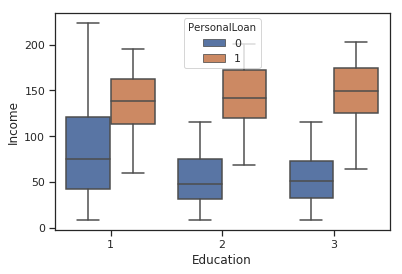

In [17]:
sns.boxplot(x='Education',y='Income',hue='PersonalLoan',data=data)

**Observation** : It seems the customers whose education level is 1 is having more income. However customers who has taken the personal loan have the same income levels

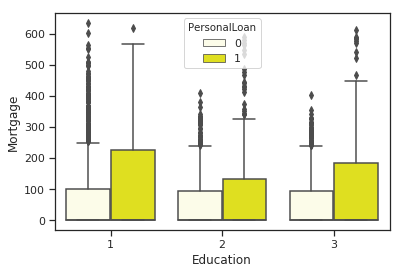

In [18]:
sns.boxplot(x="Education", y='Mortgage', hue="PersonalLoan", data=data,color='yellow')

**Inference** : From the above chart it seems that customer who do not have personal loan and customer who has personal loan have high mortgage

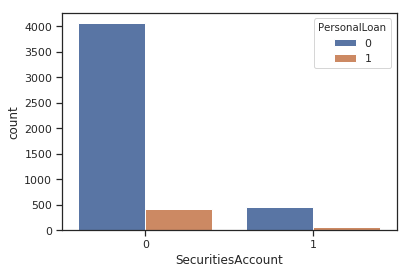

In [19]:
sns.countplot(x="SecuritiesAccount", data=data,hue="PersonalLoan")

**Observation** : Majority of customers who does not have loan have securities account

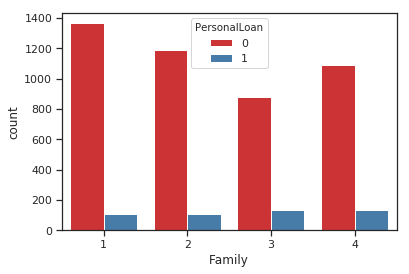

In [20]:
sns.countplot(x='Family',data=data,hue='PersonalLoan',palette='Set1')

**Observation** : Family size does not have any impact in personal loan. But it seems families with size of 3 are more likely to take loan. When considering future campaign this might be good association.

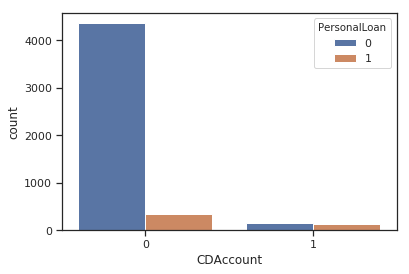

In [21]:
sns.countplot(x='CDAccount',data=data,hue='PersonalLoan')

**Observation** : Customers who does not have CD account , does not have loan as well. This seems to be majority. But almost all customers who has CD account has loan as well

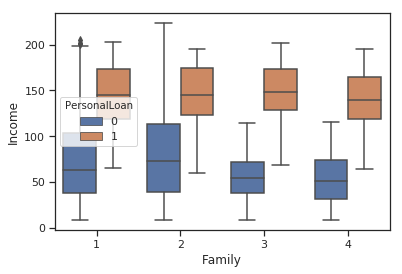

In [22]:
sns.boxplot(x=data.Family,y=data.Income,hue=data.PersonalLoan)

**Observation** : Looking at the above plot, families with income less than 100K are less likely to take loan, than families with high income

In [23]:
print('Credit card spending of Non-Loan customers: ',data[data.PersonalLoan == 0]['CCAvg'].median()*1000)
print('Credit card spending of Loan customers    : ', data[data.PersonalLoan == 1]['CCAvg'].median()*1000)

Credit card spending of Non-Loan customers:  1400.0
Credit card spending of Loan customers    :  3800.0


### Develop a Naive Bayes Model

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

Split the data in to Training(70%) and Testing(30%) 

In [25]:
train_set, test_set = train_test_split(data.drop(['ID','Experience'], axis=1), test_size=0.3 , random_state=100)

In [26]:
train_labels = train_set.pop('PersonalLoan')
test_labels = test_set.pop('PersonalLoan')

#### Train the Model and get Predictions

In [27]:
naive_model = GaussianNB()
naive_model.fit(train_set, train_labels)

prediction = naive_model.predict(test_set)
naive_model.score(test_set,test_labels)

0.8866666666666667

#### The model scores an accuracy of 88.67%

In [28]:
print(prediction)

[0 0 0 ... 1 0 1]


# Deploy the model to Watson Machine Learning

In [ ]:
!pip uninstall --yes watson-machine-learning-client

In [ ]:
!pip install watson-machine-learning-client-V4

In [29]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

In [30]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [31]:
instance_details = client.service_instance.get_details()

In [32]:
metadata = {
    client.repository.ModelMetaNames.NAME: 'Personal Loan Prediction Model',
    client.repository.ModelMetaNames.TYPE: "scikit-learn_0.20",
    client.repository.ModelMetaNames.RUNTIME_UID: "scikit-learn_0.20-py3.6"  
}

In [33]:
published_model = client.repository.store_model(model=naive_model, meta_props=metadata, \
                                                training_data=train_set, training_target=train_labels)

In [ ]:
import json
published_model_uid = client.repository.get_model_uid(published_model)
model_details = client.repository.get_details(published_model_uid)

print(json.dumps(model_details, indent=2))

In [ ]:
models_details = client.repository.list_models()

In [36]:
loaded_model = client.repository.load(published_model_uid)

In [37]:
test_predictions = loaded_model.predict(test_set[:10])

In [38]:
# The predictions made by the model.
print(test_predictions)

[0 0 0 0 0 0 1 0 0 0]


In [39]:
deploy_meta = {
     client.deployments.ConfigurationMetaNames.NAME: 'Deployment of Personal Loan Prediction',
     client.deployments.ConfigurationMetaNames.ONLINE: {}
}

In [ ]:
created_deployment = client.deployments.create(published_model_uid, meta_props=deploy_meta)

In [41]:
deployments = client.deployments.get_details()
scoring_endpoint = client.deployments.get_scoring_href(created_deployment)

In [ ]:
print(scoring_endpoint)

In [43]:
job_payload = {
client.deployments.ScoringMetaNames.INPUT_DATA: [{
 'values': [[39,139,95616,3,3.4,1,483,0,0,1,0]]
}]
}
print(job_payload)

{'input_data': [{'values': [[39, 139, 95616, 3, 3.4, 1, 483, 0, 0, 1, 0]]}]}


In [44]:
did = client.deployments.get_uid(created_deployment)

In [45]:
predictions = client.deployments.score(did, job_payload)

In [46]:
print(json.dumps(predictions, indent=2))

{
  "predictions": [
    {
      "fields": [
        "prediction",
        "probability"
      ],
      "values": [
        [
          1,
          [
            0.006869522647686105,
            0.9931304773523116
          ]
        ]
      ]
    }
  ]
}


In [47]:
print(predictions["predictions"][0]['values'][0][0])

1
